# Integrantes

- Sergio Orellana 221122
- Andre Marroquin 22266

## Instalación 

In [25]:
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.enums import Resampling
from rasterio.mask import mask
from rasterio.warp import reproject, calculate_default_transform

try:
    import geopandas as gpd
    HAS_GPD = True
except Exception:
    HAS_GPD = False

from shapely.geometry import box, mapping

from matplotlib.backends.backend_pdf import PdfPages


## Parámetros de ENTRADA (RUTAS, AOI, UMBRALES)

In [26]:
WORKDIR = Path(r"C:\Users\andre\OneDrive\Desktop\Lab3-DS")

AOI_MODE = "FULL"  

AOI_BOX_BOUNDS = None  
SHAPEFILE_PATH = None  

B04_2020 = WORKDIR / "2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
B08_2020 = WORKDIR / "2020-03-05-00_00_2020-03-05-23_59_Sentinel-2_L2A_B08_(Raw).tiff"
B04_2024 = WORKDIR / "2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B04_(Raw).tiff"
B08_2024 = WORKDIR / "2024-01-09-00_00_2024-01-09-23_59_Sentinel-2_L2A_B08_(Raw).tiff"

LOSS_THRESHOLD = -0.2           
NDVI_VEG_THRESHOLD_2020 = 0.2  

OUTDIR = WORKDIR / "salidas_ndvi"
OUTDIR.mkdir(exist_ok=True)


## Utilidades (Lectura, Alineación, Recorte, Nube)


In [27]:
def LEER_RASTER(ALGO):
    return rasterio.open(ALGO)

def EXTRAER_FECHA_DESDE_NOMBRE(PATHLIKE):
    S = Path(PATHLIKE).name
    M = re.search(r"(\d{4}-\d{2}-\d{2})", S)
    return M.group(1) if M else "FECHA_DESCONOCIDA"

def ALINEAR_A_REFERENCIA(SRC_PATH, REF_PROFILE):
    with rasterio.open(SRC_PATH) as src:
        DEST = np.zeros((REF_PROFILE["height"], REF_PROFILE["width"]), dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=DEST,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=REF_PROFILE["transform"],
            dst_crs=REF_PROFILE["crs"],
            resampling=Resampling.bilinear
        )
    return DEST

def PERFIL_REFERENCIA(BASE_PATH):
    with rasterio.open(BASE_PATH) as src:
        PROFILE = src.profile.copy()
        PROFILE.update({
            "dtype": "float32",
            "count": 1,
            "compress": "deflate",
            "predictor": 2,
        })
    return PROFILE

def RECORTAR_AOI(DATA, PROFILE, AOI_MODE, AOI_BOX_BOUNDS=None, SHAPEFILE_PATH=None):
    if AOI_MODE == "FULL":
        return DATA, PROFILE

    if AOI_MODE == "BOX":
        if AOI_BOX_BOUNDS is None:
            raise ValueError("DEBES DEFINIR AOI_BOX_BOUNDS PARA MODO 'BOX'")
        GEOM = [mapping(box(*AOI_BOX_BOUNDS))]
    elif AOI_MODE == "SHAPE":
        if SHAPEFILE_PATH is None:
            raise ValueError("DEBES DEFINIR SHAPEFILE_PATH PARA MODO 'SHAPE'")
        if not HAS_GPD:
            raise ImportError("GEOPANDAS NO DISPONIBLE. INSTÁLALO O USA 'BOX'/'FULL'")
        GDF = gpd.read_file(SHAPEFILE_PATH)
        with rasterio.Env():
            with rasterio.open(PROFILE["transform"]) if False else None:
                pass
        GEOM = [mapping(g) for g in GDF.to_crs(PROFILE["crs"]).geometry]
    else:
        raise ValueError("AOI_MODE DESCONOCIDO")

    with rasterio.io.MemoryFile() as MEM:
        with MEM.open(**PROFILE) as TMP:
            TMP.write(DATA.astype(np.float32), 1)
            OUT, OUT_TRANSFORM = mask(TMP, GEOM, crop=True, filled=True, nodata=np.nan)
            OUT = OUT[0]
            NEW_PROFILE = PROFILE.copy()
            NEW_PROFILE.update({
                "height": OUT.shape[0],
                "width": OUT.shape[1],
                "transform": OUT_TRANSFORM
            })
    return OUT, NEW_PROFILE

def BUSCAR_CALIDAD(BASEDIR, FECHA):
    CANDIDATOS = list(BASEDIR.glob(f"*{FECHA}*SCL*.tif*")) + list(BASEDIR.glob(f"*{FECHA}*QA60*.tif*"))
    return CANDIDATOS[0] if CANDIDATOS else None

def MASCARA_NUBES_O_QA(QUALITY_PATH, REF_PROFILE):
    if QUALITY_PATH is None:
        return None
    with rasterio.open(QUALITY_PATH) as src:
        ARR = np.zeros((REF_PROFILE["height"], REF_PROFILE["width"]), dtype=np.float32)
        reproject(
            source=rasterio.band(src, 1),
            destination=ARR,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=REF_PROFILE["transform"],
            dst_crs=REF_PROFILE["crs"],
            resampling=Resampling.nearest
        )
    ARR = ARR.astype(np.int32)

    NAME = Path(QUALITY_PATH).name.upper()
    if "SCL" in NAME:
        CLOUD_CLASSES = {3, 8, 9, 10, 11}  
        MASK = np.isin(ARR, list(CLOUD_CLASSES))
    else:
        MASK = ARR > 0
    return MASK


## Cargar, Alinear, Recortar y Aplicar Nubes

In [28]:
REF_PROFILE = PERFIL_REFERENCIA(B08_2020)

B04_2020_ALIGNED = ALINEAR_A_REFERENCIA(B04_2020, REF_PROFILE)
B08_2020_ALIGNED = ALINEAR_A_REFERENCIA(B08_2020, REF_PROFILE)
B04_2024_ALIGNED = ALINEAR_A_REFERENCIA(B04_2024, REF_PROFILE)
B08_2024_ALIGNED = ALINEAR_A_REFERENCIA(B08_2024, REF_PROFILE)

B04_2020_CROP, CROP_PROFILE = RECORTAR_AOI(B04_2020_ALIGNED, REF_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B08_2020_CROP, CROP_PROFILE = RECORTAR_AOI(B08_2020_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B04_2024_CROP, CROP_PROFILE = RECORTAR_AOI(B04_2024_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)
B08_2024_CROP, CROP_PROFILE = RECORTAR_AOI(B08_2024_ALIGNED, CROP_PROFILE, AOI_MODE, AOI_BOX_BOUNDS, SHAPEFILE_PATH)

NODATA_MASK = (B04_2020_CROP == 0) | (B08_2020_CROP == 0) | (B04_2024_CROP == 0) | (B08_2024_CROP == 0)

FECHA_2020 = EXTRAER_FECHA_DESDE_NOMBRE(B04_2020)
FECHA_2024 = EXTRAER_FECHA_DESDE_NOMBRE(B04_2024)

Q_2020 = BUSCAR_CALIDAD(WORKDIR, FECHA_2020)
Q_2024 = BUSCAR_CALIDAD(WORKDIR, FECHA_2024)

CLOUD_2020 = MASCARA_NUBES_O_QA(Q_2020, CROP_PROFILE) if Q_2020 else None
CLOUD_2024 = MASCARA_NUBES_O_QA(Q_2024, CROP_PROFILE) if Q_2024 else None

MASK_2020 = NODATA_MASK | (CLOUD_2020 if CLOUD_2020 is not None else False)
MASK_2024 = NODATA_MASK | (CLOUD_2024 if CLOUD_2024 is not None else False)

## Cálculo de NDVI, Diferencia y Máscara de Deforestación

In [29]:
def CALC_NDVI(NIR, RED, MASK):
    NIR = NIR.astype(np.float32)
    RED = RED.astype(np.float32)
    NUM = NIR - RED
    DEN = NIR + RED
    NDVI = np.divide(NUM, DEN, out=np.full_like(NUM, np.nan, dtype=np.float32), where=DEN!=0)
    NDVI[MASK] = np.nan
    return NDVI

NDVI_2020 = CALC_NDVI(B08_2020_CROP, B04_2020_CROP, MASK_2020)
NDVI_2024 = CALC_NDVI(B08_2024_CROP, B04_2024_CROP, MASK_2024)

NDVI_DIFF = NDVI_2024 - NDVI_2020  

LOST_BOOL = (NDVI_DIFF < LOSS_THRESHOLD) & (NDVI_2020 > NDVI_VEG_THRESHOLD_2020)
LOST_BOOL[np.isnan(NDVI_DIFF) | np.isnan(NDVI_2020)] = False


## Cálculo de Áreas (% y ha)

In [30]:
PIXEL_WIDTH = abs(CROP_PROFILE["transform"].a)
PIXEL_HEIGHT = abs(CROP_PROFILE["transform"].e)
PIXEL_AREA_M2 = PIXEL_WIDTH * PIXEL_HEIGHT

VALID_MASK = ~np.isnan(NDVI_2020) & ~np.isnan(NDVI_2024)
AOI_AREA_M2 = VALID_MASK.sum() * PIXEL_AREA_M2
LOSS_AREA_M2 = LOST_BOOL.sum() * PIXEL_AREA_M2

AOI_AREA_HA = AOI_AREA_M2 / 10000.0
LOSS_AREA_HA = LOSS_AREA_M2 / 10000.0

LOSS_PCT_AOI = 100.0 * (LOSS_AREA_M2 / AOI_AREA_M2) if AOI_AREA_M2 > 0 else np.nan

VEG2020 = (NDVI_2020 > NDVI_VEG_THRESHOLD_2020) & ~np.isnan(NDVI_2020)
VEG2020_AREA_M2 = VEG2020.sum() * PIXEL_AREA_M2
LOSS_PCT_SOBRE_VEG2020 = 100.0 * (LOSS_AREA_M2 / VEG2020_AREA_M2) if VEG2020_AREA_M2 > 0 else np.nan

RESUMEN = {
    "FECHA_2020": FECHA_2020,
    "FECHA_2024": FECHA_2024,
    "LOSS_THRESHOLD": LOSS_THRESHOLD,
    "NDVI_VEG_THRESHOLD_2020": NDVI_VEG_THRESHOLD_2020,
    "PIXEL_AREA_M2": PIXEL_AREA_M2,
    "AOI_AREA_HA": AOI_AREA_HA,
    "LOSS_AREA_HA": LOSS_AREA_HA,
    "LOSS_PCT_AOI": LOSS_PCT_AOI,
    "VEG2020_AREA_HA": VEG2020_AREA_M2 / 10000.0,
    "LOSS_PCT_SOBRE_VEG2020": LOSS_PCT_SOBRE_VEG2020,
}
print(RESUMEN)

{'FECHA_2020': '2020-03-05', 'FECHA_2024': '2024-01-09', 'LOSS_THRESHOLD': -0.2, 'NDVI_VEG_THRESHOLD_2020': 0.2, 'PIXEL_AREA_M2': 7.99782119185285e-07, 'AOI_AREA_HA': np.float64(0.0002873079700648636), 'LOSS_AREA_HA': np.float64(4.054495453209802e-06), 'LOSS_PCT_AOI': np.float64(1.4112018724348112), 'VEG2020_AREA_HA': np.float64(0.0002831103136123197), 'LOSS_PCT_SOBRE_VEG2020': np.float64(1.4321256620703233)}


##  Visualizaciones solicitadas

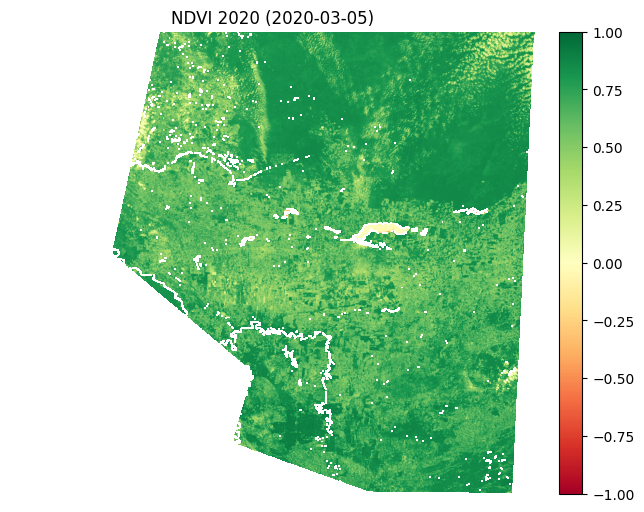

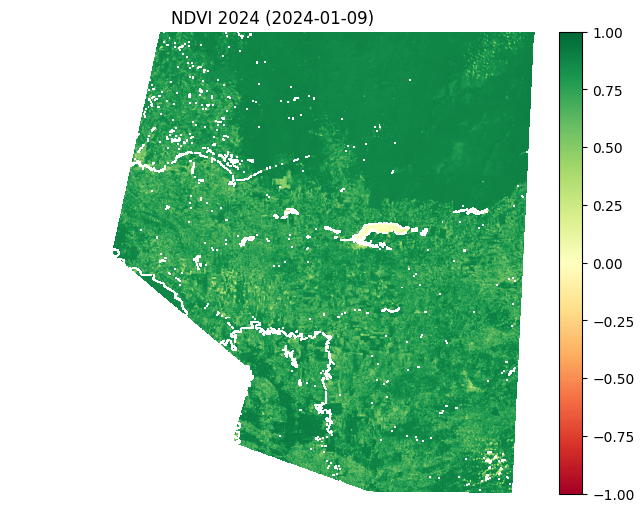

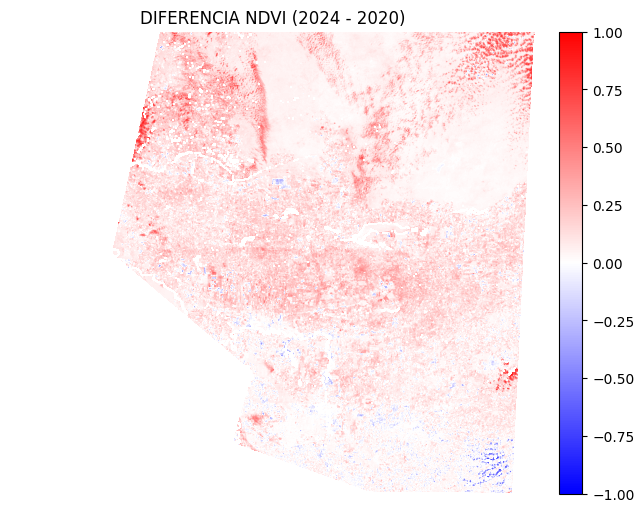

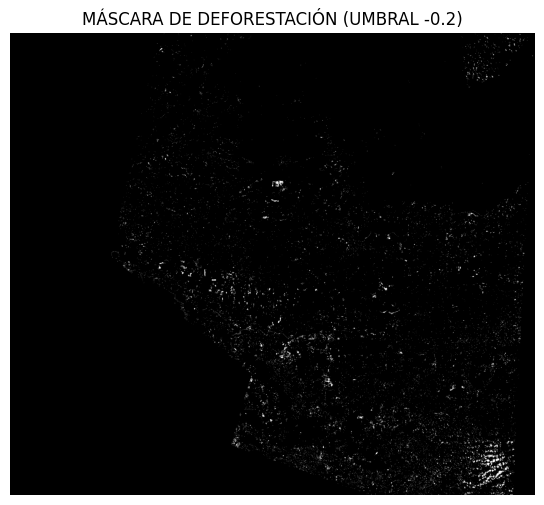

In [31]:
# NDVI 2020
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_2020, vmin=-1, vmax=1, cmap="RdYlGn")
plt.title(f"NDVI 2020 ({FECHA_2020})")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# NDVI 2024
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_2024, vmin=-1, vmax=1, cmap="RdYlGn")
plt.title(f"NDVI 2024 ({FECHA_2024})")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# DIFERENCIA (2024 - 2020)
plt.figure(figsize=(8,6))
IM = plt.imshow(NDVI_DIFF, vmin=-1, vmax=1, cmap="bwr")
plt.title("DIFERENCIA NDVI (2024 - 2020)")
plt.colorbar(IM, fraction=0.046, pad=0.04)
plt.axis("off")
plt.show()

# MÁSCARA DE DEFORESTACIÓN
plt.figure(figsize=(8,6))
IM = plt.imshow(LOST_BOOL, cmap="gray")
plt.title(f"MÁSCARA DE DEFORESTACIÓN (UMBRAL {LOSS_THRESHOLD})")
plt.axis("off")
plt.show()


## Exportar GeoTIFFs (NDVI, Diferencia, Máscara)

In [32]:
def GUARDAR_GEOTIFF(ARRAY, PROFILE, OUTPATH, DTYPE="float32", NODATA=np.nan):
    PROFILE = PROFILE.copy()
    PROFILE.update({"dtype": DTYPE, "count": 1, "nodata": NODATA})
    with rasterio.open(OUTPATH, "w", **PROFILE) as dst:
        if np.issubdtype(ARRAY.dtype, np.floating) and np.isnan(NODATA):
            dst.write(ARRAY.astype(np.float32), 1)
        else:
            dst.write(ARRAY.astype(PROFILE["dtype"]), 1)

# RUTAS
OUT_NDVI_2020 = OUTDIR / "NDVI_2020.tif"
OUT_NDVI_2024 = OUTDIR / "NDVI_2024.tif"
OUT_DIFF = OUTDIR / "NDVI_DIFF_2024_MINUS_2020.tif"
OUT_MASK = OUTDIR / "DEFORESTACION_MASK.tif"

GUARDAR_GEOTIFF(NDVI_2020, CROP_PROFILE, OUT_NDVI_2020, "float32", np.nan)
GUARDAR_GEOTIFF(NDVI_2024, CROP_PROFILE, OUT_NDVI_2024, "float32", np.nan)
GUARDAR_GEOTIFF(NDVI_DIFF, CROP_PROFILE, OUT_DIFF, "float32", np.nan)
GUARDAR_GEOTIFF(LOST_BOOL.astype(np.uint8), CROP_PROFILE, OUT_MASK, "uint8", 0)

print("GEOTIFFS GUARDADOS EN:", OUTDIR)


GEOTIFFS GUARDADOS EN: C:\Users\andre\OneDrive\Desktop\Lab3-DS\salidas_ndvi
